In [1]:
pip install numpy pandas pydicom opencv-python scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import zipfile

# 1️⃣ Extract ZIP
def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted {zip_path} to {extract_to}")

# 2️⃣ Get all image/mask files (including .tif)
def get_all_files(directory, exts=('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
    return sorted([
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.lower().endswith(exts)
    ])

# 3️⃣ Match image-mask pairs by filename
def get_matched_pairs(image_files, mask_files):
    print("\n🧾 Sample image filenames:")
    print([os.path.basename(f) for f in image_files[:5]])
    print("🧾 Sample mask filenames:")
    print([os.path.basename(f) for f in mask_files[:5]])

    mask_dict = {}
    for f in mask_files:
        base = os.path.splitext(os.path.basename(f))[0]
        base = base.replace('_mask', '').replace('-mask', '')
        mask_dict[base] = f

    image_paths, mask_paths = [], []
    for img_file in image_files:
        base = os.path.splitext(os.path.basename(img_file))[0]
        if base in mask_dict:
            image_paths.append(img_file)
            mask_paths.append(mask_dict[base])

    return image_paths, mask_paths

# 4️⃣ Preprocessing
def preprocess_data(image_paths, mask_paths, target_size=(256, 256)):
    X, y = [], []
    for img_path, mask_path in zip(image_paths, mask_paths):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

            if img is None or mask is None:
                print(f"⚠️ Skipping (not found): {img_path}, {mask_path}")
                continue

            img = cv2.resize(img, target_size)
            mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

            # Normalize 8-bit or 16-bit image
            img = img.astype(np.float32)
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            mask = (mask > 127).astype(np.float32)  # binary mask

            X.append(np.expand_dims(img, axis=-1))
            y.append(np.expand_dims(mask, axis=-1))

        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            continue

    return np.array(X), np.array(y)

# 5️⃣ Main
if __name__ == "__main__":
    input_dir = "/kaggle/input/finding-lungs-in-ct-data"
    output_dir = "/kaggle/working/preprocessed_data"

    image_zip = os.path.join(input_dir, "2d_images.zip")
    mask_zip = os.path.join(input_dir, "2d_masks.zip")

    image_extract_dir = os.path.join(output_dir, "images")
    mask_extract_dir = os.path.join(output_dir, "masks")

    extract_zip(image_zip, image_extract_dir)
    extract_zip(mask_zip, mask_extract_dir)

    image_files = get_all_files(image_extract_dir)
    mask_files = get_all_files(mask_extract_dir)

    print(f"\n📦 Found {len(image_files)} image files")
    print(f"📦 Found {len(mask_files)} mask files")

    image_paths, mask_paths = get_matched_pairs(image_files, mask_files)
    print(f"\n✅ Matched {len(image_paths)} image-mask pairs")

    if len(image_paths) == 0:
        raise ValueError("❌ No matched image-mask pairs found. Check filenames or dataset integrity.")

    X, y = preprocess_data(image_paths, mask_paths)
    print(f"\n✅ Preprocessed shapes: Images: {X.shape}, Masks: {y.shape}")

    # Split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2 / 0.3, random_state=42)

    print("\n📊 Dataset Split:")
    print("Train:", X_train.shape, y_train.shape)
    print("Val  :", X_val.shape, y_val.shape)
    print("Test :", X_test.shape, y_test.shape)

    # Save
    np.savez_compressed(os.path.join(output_dir, "lung_segmentation_data.npz"),
                        X_train=X_train, y_train=y_train,
                        X_val=X_val, y_val=y_val,
                        X_test=X_test, y_test=y_test)

    print(f"\n💾 Saved preprocessed data to: {output_dir}/lung_segmentation_data.npz")


✅ Extracted /kaggle/input/finding-lungs-in-ct-data/2d_images.zip to /kaggle/working/preprocessed_data/images
✅ Extracted /kaggle/input/finding-lungs-in-ct-data/2d_masks.zip to /kaggle/working/preprocessed_data/masks

📦 Found 267 image files
📦 Found 267 mask files

🧾 Sample image filenames:
['ID_0000_Z_0142.tif', 'ID_0001_Z_0146.tif', 'ID_0002_Z_0162.tif', 'ID_0003_Z_0132.tif', 'ID_0004_Z_0066.tif']
🧾 Sample mask filenames:
['ID_0000_Z_0142.tif', 'ID_0001_Z_0146.tif', 'ID_0002_Z_0162.tif', 'ID_0003_Z_0132.tif', 'ID_0004_Z_0066.tif']

✅ Matched 267 image-mask pairs

✅ Preprocessed shapes: Images: (267, 256, 256, 1), Masks: (267, 256, 256, 1)

📊 Dataset Split:
Train: (186, 256, 256, 1) (186, 256, 256, 1)
Val  : (26, 256, 256, 1) (26, 256, 256, 1)
Test : (55, 256, 256, 1) (55, 256, 256, 1)

💾 Saved preprocessed data to: /kaggle/working/preprocessed_data/lung_segmentation_data.npz


2025-06-21 16:55:34.473203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750524934.766249      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750524934.844689      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750524949.707802      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750524949.708478      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/30


I0000 00:00:1750524975.803489     107 service.cc:148] XLA service 0x79beb8005960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750524975.804759     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750524975.804787     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750524978.241734     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750525010.691717     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/12 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.5507 - loss: 0.6935 - precision: 0.3099 - recall: 0.7203

E0000 00:00:1750525023.276484     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750525023.496245     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


12/12 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6081 - loss: 0.6503 - precision: 0.3531 - recall: 0.7617 - val_accuracy: 0.5812 - val_loss: 0.6858 - val_precision: 0.2566 - val_recall: 0.3887
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.8915 - loss: 0.4084 - precision: 0.7246 - recall: 0.8849 - val_accuracy: 0.2595 - val_loss: 0.7355 - val_precision: 0.2456 - val_recall: 1.0000
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.9644 - loss: 0.2712 - precision: 0.9169 - recall: 0.9368 - val_accuracy: 0.2502 - val_loss: 2.3608 - val_precision: 0.2433 - val_recall: 1.0000
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.9770 - loss: 0.2232 - precision: 0.9581 - recall: 0.9439 - val_accuracy: 0.5593 - val_loss: 1.2141 - val_precision: 0.3512 - val_recall: 0.9779
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.9821 - loss: 0.1932 - precision: 0.9773 - recall: 0.9476 - val_accuracy: 0.6225 - val_loss: 0.8241 - val_pr

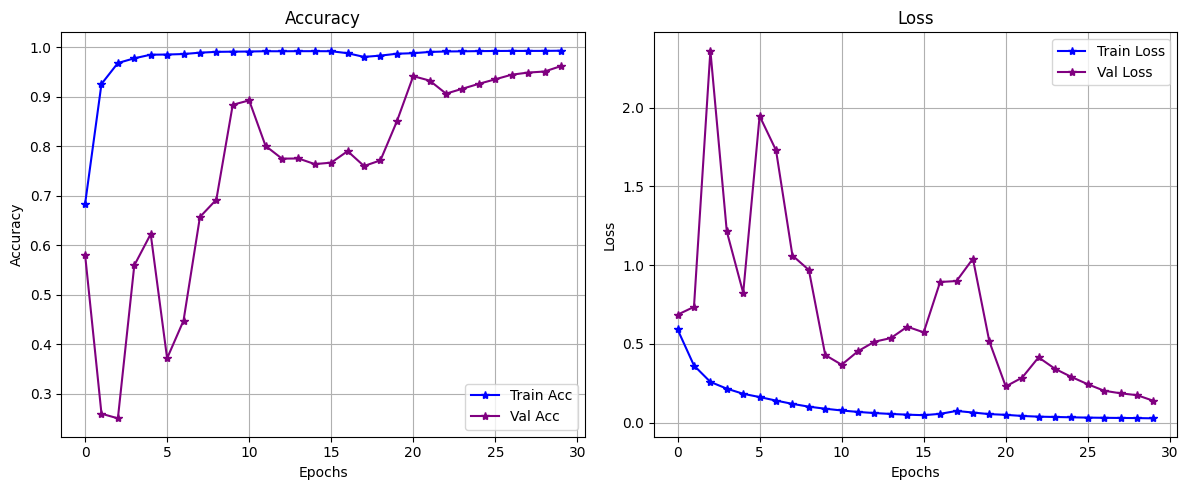

2025-06-21 16:59:39.758566: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-21 16:59:39.759872: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.001482435s
Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 18s/step


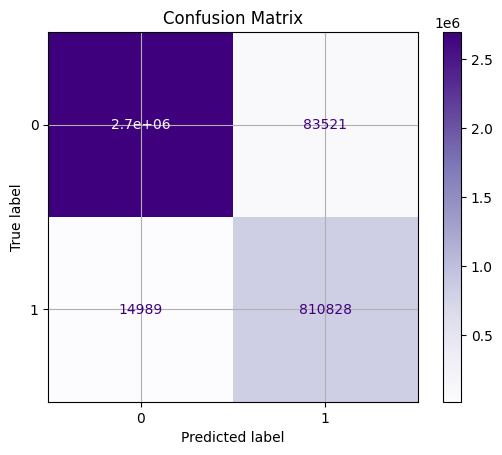


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98   2778663
         1.0       0.91      0.98      0.94    825817

    accuracy                           0.97   3604480
   macro avg       0.95      0.98      0.96   3604480
weighted avg       0.97      0.97      0.97   3604480



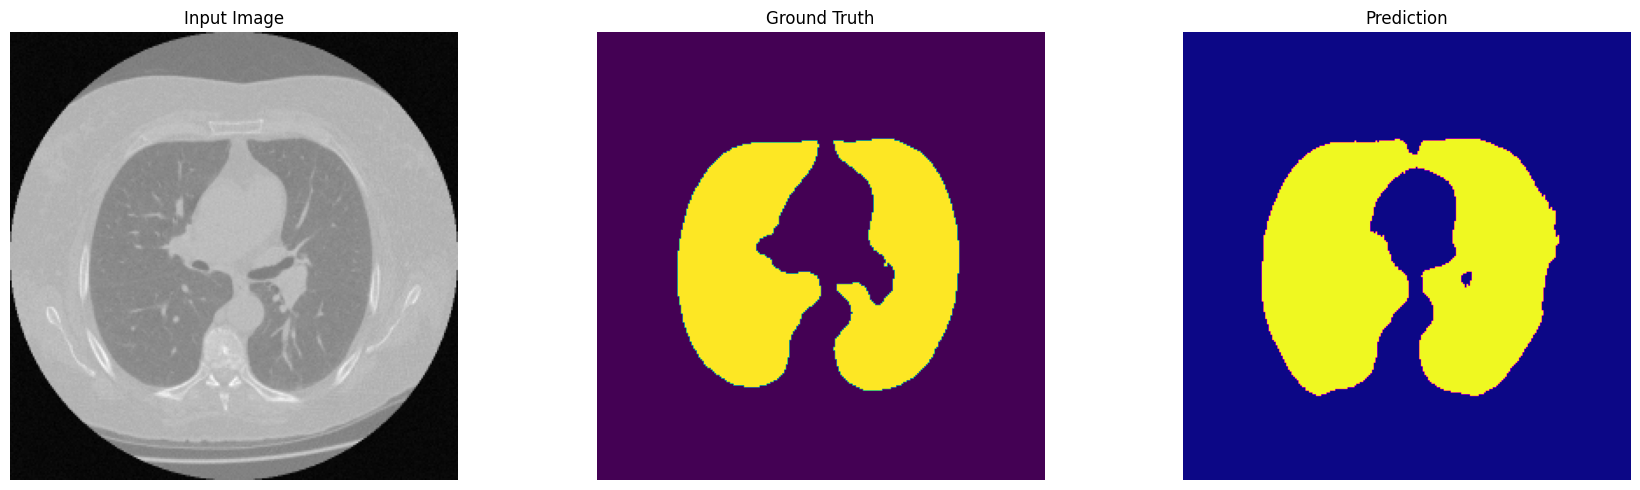

In [ ]:
# Improved GA-UNet with Attention Mechanism (TensorFlow/Keras + Visualization + Evaluation)

import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# === Load Preprocessed Data ===
data = np.load("/kaggle/working/preprocessed_data/lung_segmentation_data.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

# === TensorFlow Datasets ===
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).shuffle(100)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

# === Visualization Functions ===
def display_sample(image, mask, prediction=None, colored=False):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    if colored:
        plt.imshow(mask.squeeze(), cmap='viridis')
    else:
        plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')

    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        if colored:
            plt.imshow(prediction.squeeze(), cmap='plasma')
        else:
            plt.imshow(prediction.squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], '*-', label='Train Acc', color='blue')
    plt.plot(history.history['val_accuracy'], '*-', label='Val Acc', color='purple')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '*-', label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], '*-', label='Val Loss', color='purple')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Squeeze-and-Excitation block ===
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

# === Convolution block with optional attention ===
def conv_block(x, filters, kernel_size=3, activation='relu', attention=False):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    if attention:
        x = se_block(x)
    return x

# === Build Attention U-Net ===
def build_attention_unet(input_shape, num_classes, base_filters=32, attention=True):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = conv_block(inputs, base_filters, attention=attention)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = conv_block(p1, base_filters * 2, attention=attention)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = conv_block(p2, base_filters * 4, attention=attention)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    e4 = conv_block(p3, base_filters * 8, attention=attention)
    p4 = layers.MaxPooling2D((2, 2))(e4)

    # Bottleneck
    b = conv_block(p4, base_filters * 16, attention=attention)

    # Decoder
    u4 = layers.Conv2DTranspose(base_filters * 8, 2, strides=(2, 2), padding='same')(b)
    u4 = layers.Concatenate()([u4, e4])
    d4 = conv_block(u4, base_filters * 8, attention=attention)

    u3 = layers.Conv2DTranspose(base_filters * 4, 2, strides=(2, 2), padding='same')(d4)
    u3 = layers.Concatenate()([u3, e3])
    d3 = conv_block(u3, base_filters * 4, attention=attention)

    u2 = layers.Conv2DTranspose(base_filters * 2, 2, strides=(2, 2), padding='same')(d3)
    u2 = layers.Concatenate()([u2, e2])
    d2 = conv_block(u2, base_filters * 2, attention=attention)

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=(2, 2), padding='same')(d2)
    u1 = layers.Concatenate()([u1, e1])
    d1 = conv_block(u1, base_filters, attention=attention)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(d1)

    return models.Model(inputs, outputs)

# === Build and Train Model ===
model = build_attention_unet((256, 256, 1), num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(), metrics.Precision()])
history = model.fit(train_ds, epochs=30, validation_data=val_ds)

# === Plot Accuracy & Loss ===
plot_history(history)

# === Evaluate on Test Set ===
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)

# Flatten for metrics
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.grid(True)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

# === Show Predictions ===
for i in range(3):
    display_sample(X_test[i], y_test[i], y_pred[i], colored=True)

# another for experiment

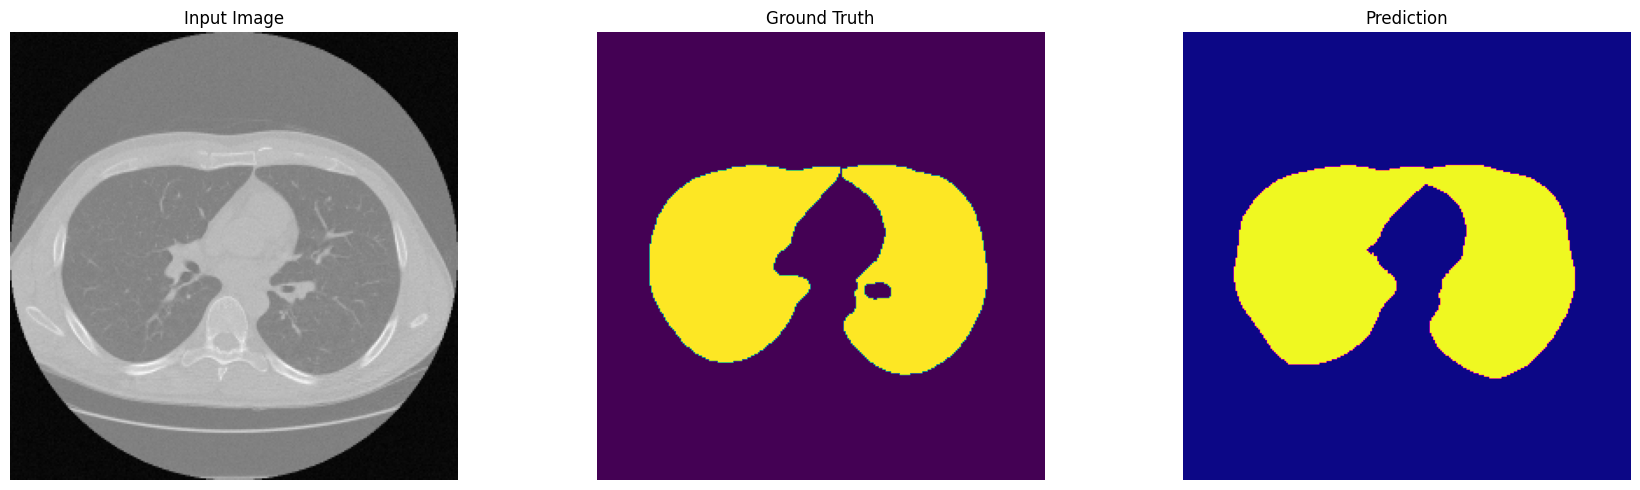

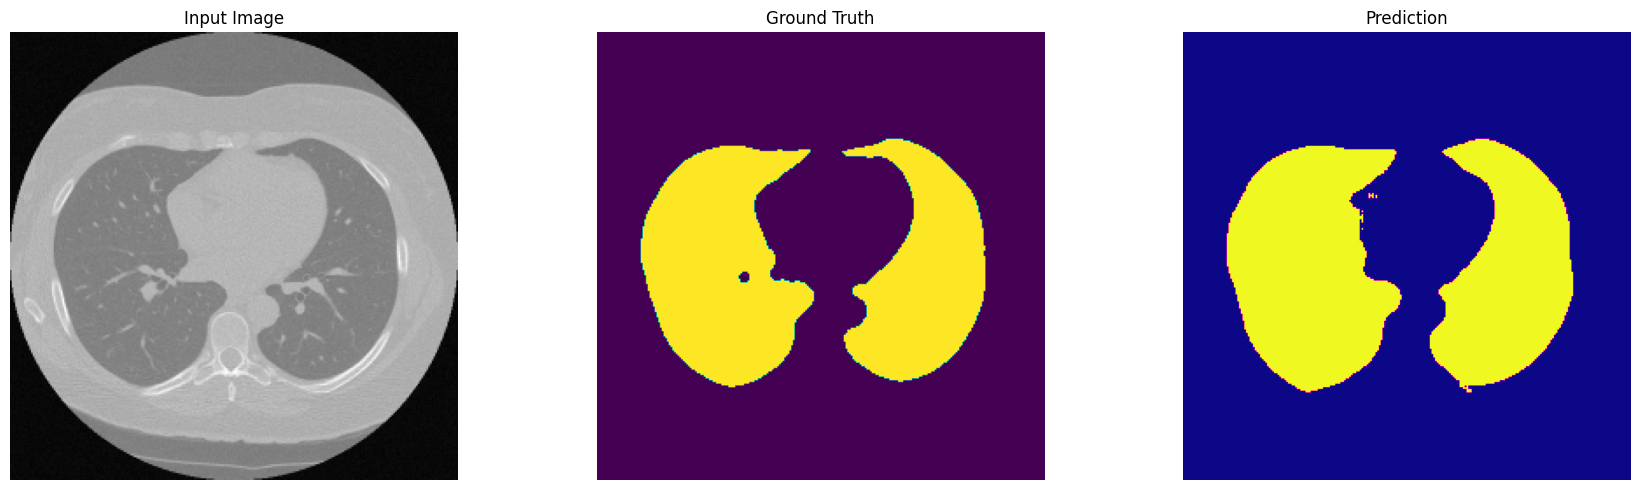

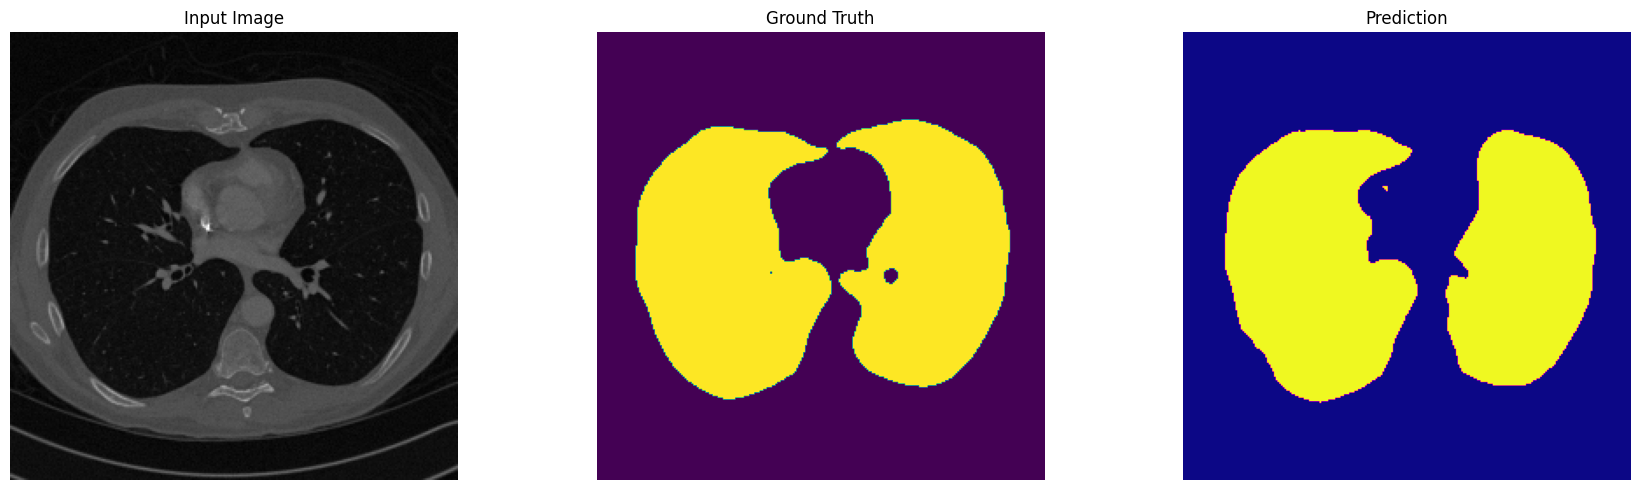

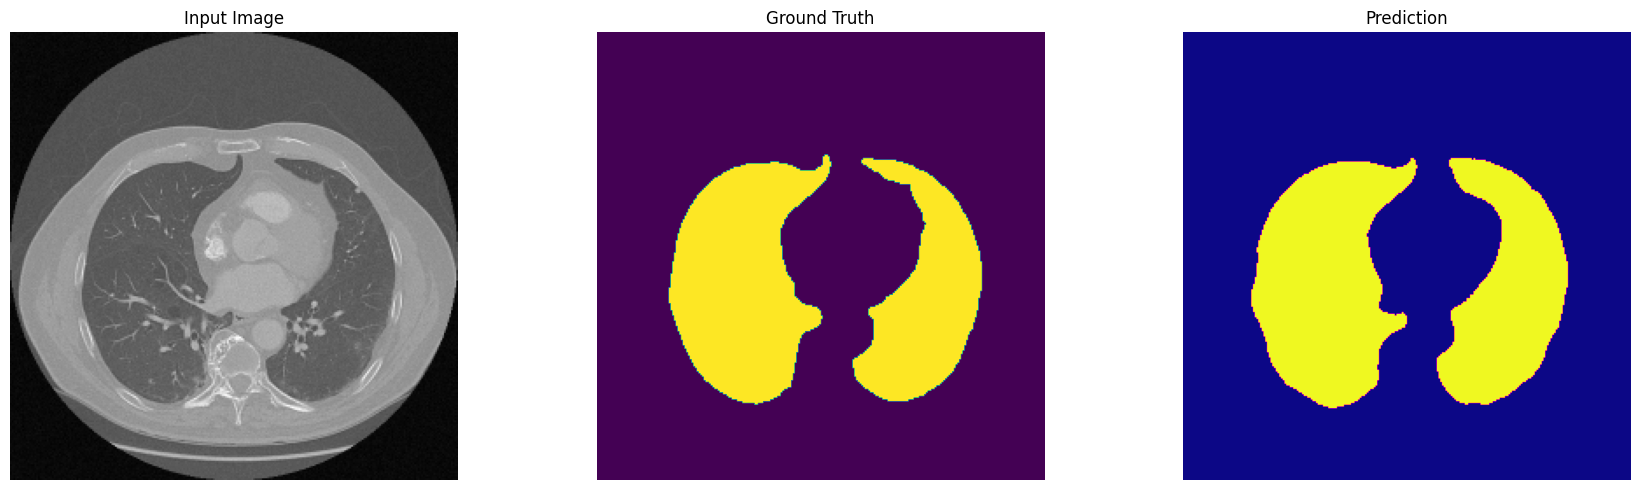

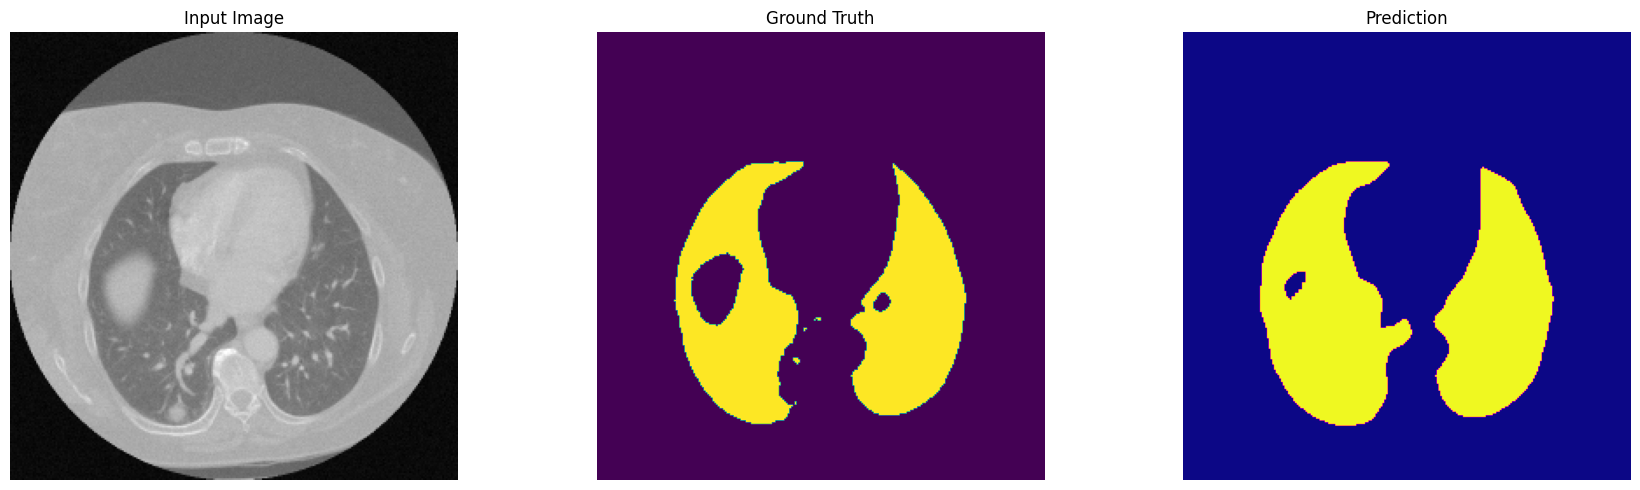

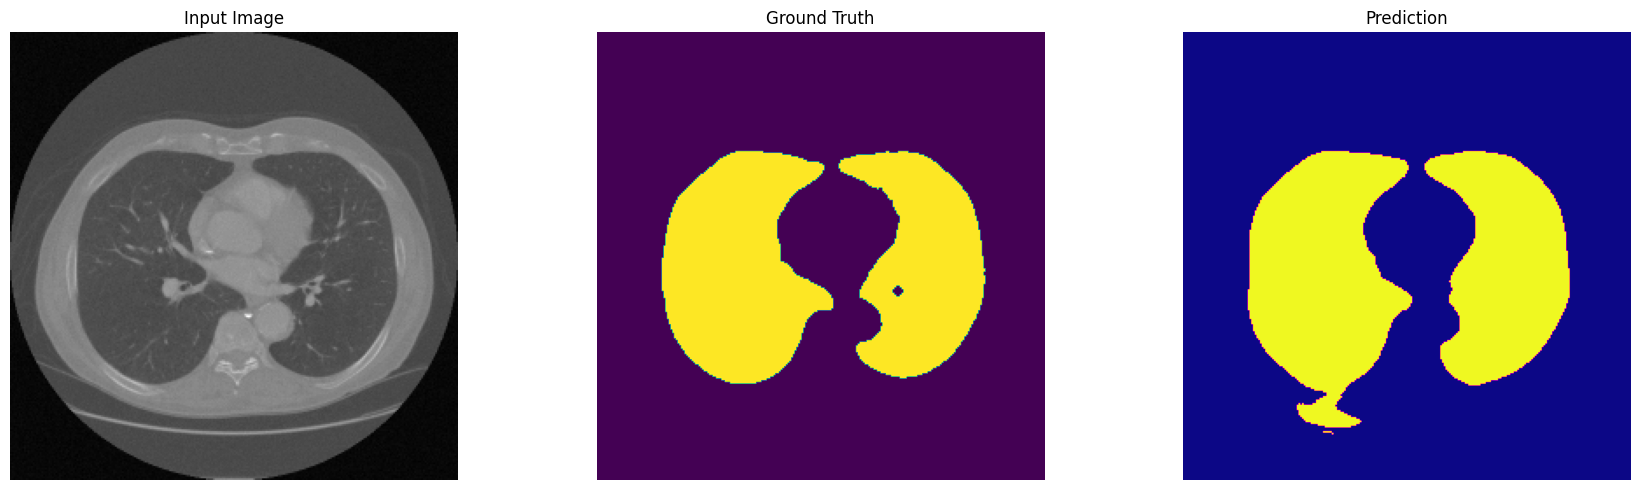


Dice Coefficient: 0.9427
IoU (Jaccard Index): 0.8917


In [12]:
# Improved GA-UNet with Attention Mechanism (TensorFlow/Keras + Visualization + Evaluation)

# [previous code unchanged...]

# === Show More Predictions ===
for i in range(6, 12):
    display_sample(X_test[i], y_test[i], y_pred[i], colored=True)

# === Additional Segmentation Metrics ===
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def jaccard_index(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

dice = dice_coefficient(y_test, y_pred)
iou = jaccard_index(y_test, y_pred)
print(f"\nDice Coefficient: {dice:.4f}")
print(f"IoU (Jaccard Index): {iou:.4f}")


# Optuna

[I 2025-06-21 17:13:21,654] A new study created in memory with name: no-name-1ad6061e-e986-4fb3-b52f-de5f27e73204
/tmp/ipykernel_35/2012653952.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
2025-06-21 17:14:00.945591: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,256,256]{3,2,1,0}, f32[32,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a w

Best hyperparameters:
{'learning_rate': 0.0006585952207667349, 'batch_size': 16, 'base_filters': 16, 'attention': True}

Hyperparameter importances:
base_filters: 0.4443
learning_rate: 0.2579
attention: 0.1707
batch_size: 0.1270


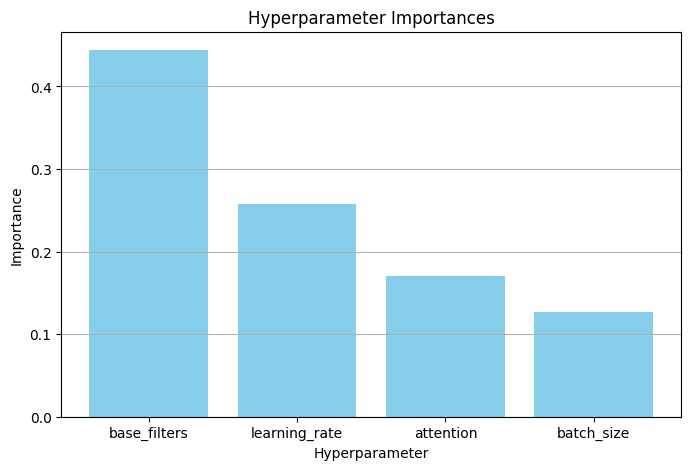

In [13]:
import optuna
from optuna.importance import get_param_importances
import optuna.visualization as vis
import tensorflow as tf
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

# Your data already loaded (X_train, y_train, X_val, y_val)

def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    base_filters = trial.suggest_categorical("base_filters", [16, 32, 64])
    attention = trial.suggest_categorical("attention", [True, False])

    # Prepare datasets
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(100)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

    # Build and compile model
    model = build_attention_unet((256, 256, 1), num_classes=1, base_filters=base_filters, attention=attention)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', metrics.Recall(), metrics.Precision()]
    )

    # Train (shorter epochs for tuning speed)
    history = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=0)

    # Return last val_accuracy as objective
    return history.history['val_accuracy'][-1]

# Create and run study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=3600)

# Best hyperparameters
print("Best hyperparameters:")
print(study.best_trial.params)

# Calculate importances
importance = get_param_importances(study)
print("\nHyperparameter importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")

# Plot parameter importances (interactive plot)
fig = vis.plot_param_importances(study)
fig.show()

# Also plot importance bar chart with matplotlib for non-interactive environments:
plt.figure(figsize=(8, 5))
plt.bar(importance.keys(), importance.values(), color='skyblue')
plt.title("Hyperparameter Importances")
plt.ylabel("Importance")
plt.xlabel("Hyperparameter")
plt.grid(axis='y')
plt.show()


# hyperparameter tunning

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.7420 - loss: 1.2237 - precision_32: 0.3961 - recall_32: 0.2422 - val_accuracy: 0.7593 - val_loss: 1.3528 - val_precision_32: 0.9809 - val_recall_32: 0.0015
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8767 - loss: 1.0044 - precision_32: 0.6946 - recall_32: 0.8680 - val_accuracy: 0.4475 - val_loss: 1.3618 - val_precision_32: 0.2782 - val_recall_32: 0.8101
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9681 - loss: 0.8689 - precision_32: 0.9176 - recall_32: 0.9519 - val_accuracy: 0.2555 - val_loss: 1.3762 - val_precision_32: 0.2446 - val_recall_32: 1.0000
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9808 - loss: 0.7965 - precision_32: 0.9529 - recall_32: 0.9662 - val_accuracy: 0.2711 - val_loss: 1.3723 - val_precision_32: 0.2485 - val_recall_32: 1.0000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.9843 - loss: 0.7539 - precision_32: 0.9555 

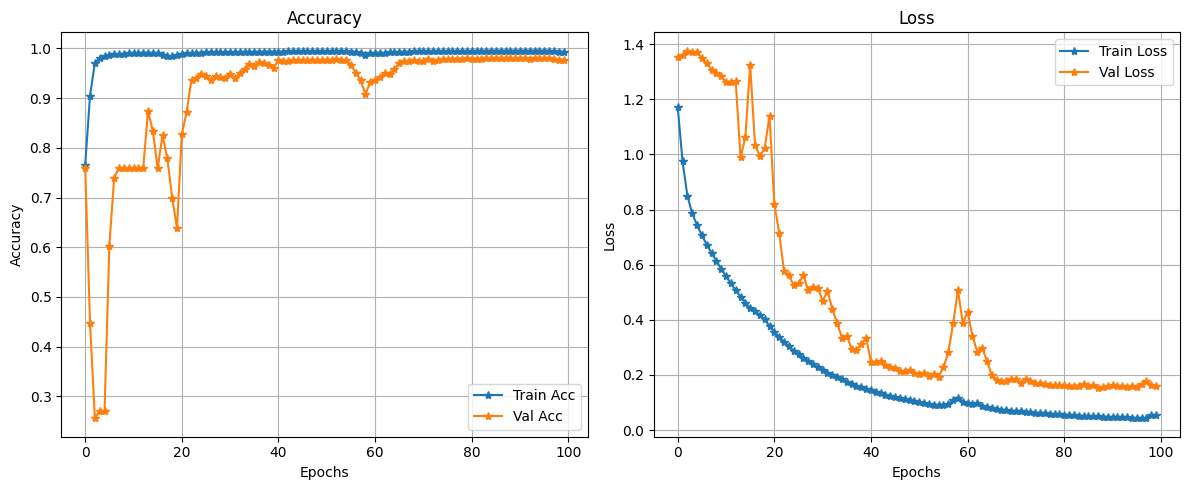

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


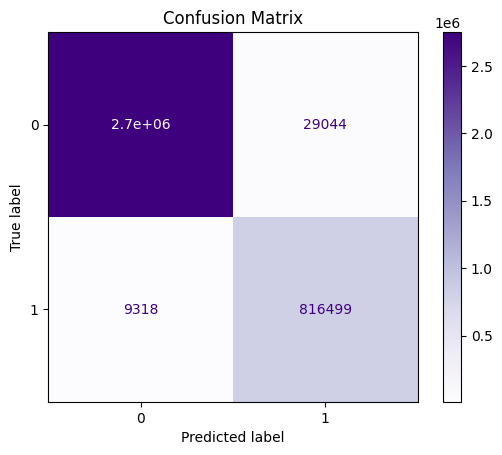


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   2778663
         1.0       0.97      0.99      0.98    825817

    accuracy                           0.99   3604480
   macro avg       0.98      0.99      0.99   3604480
weighted avg       0.99      0.99      0.99   3604480



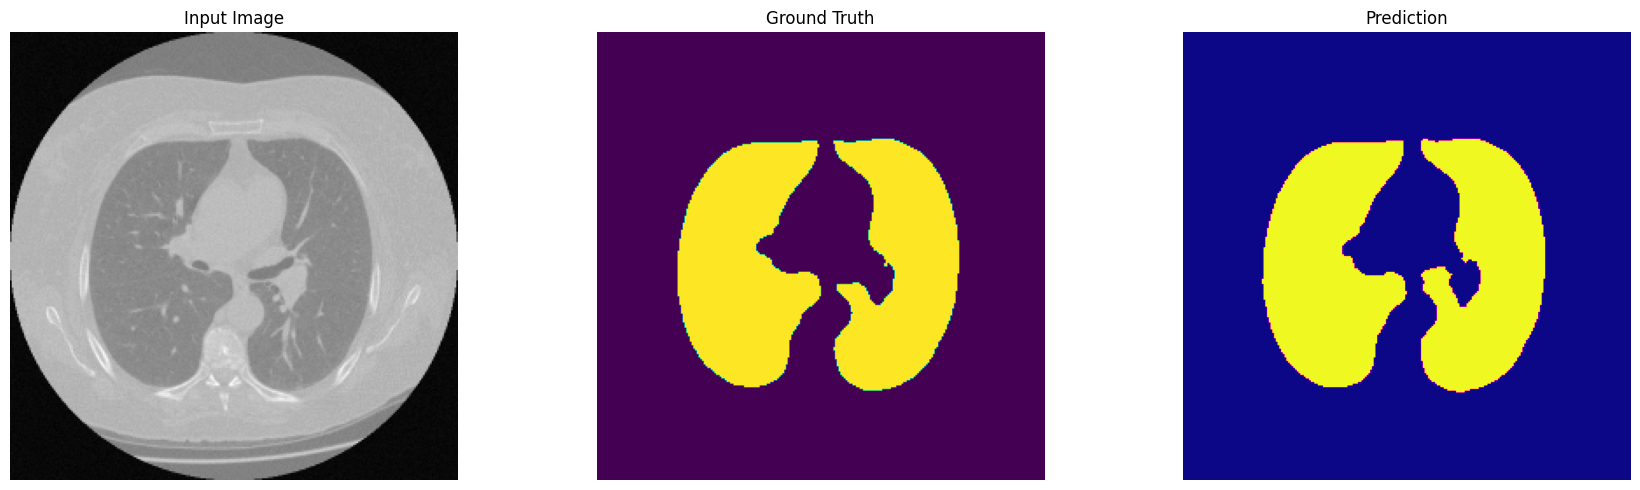

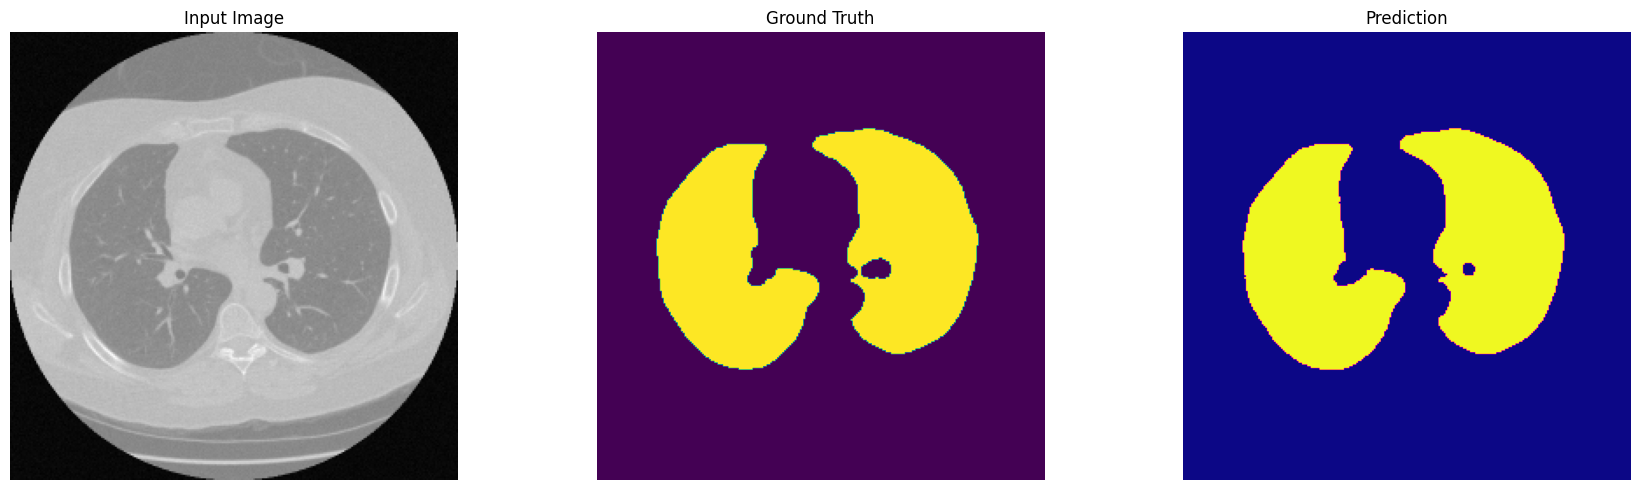

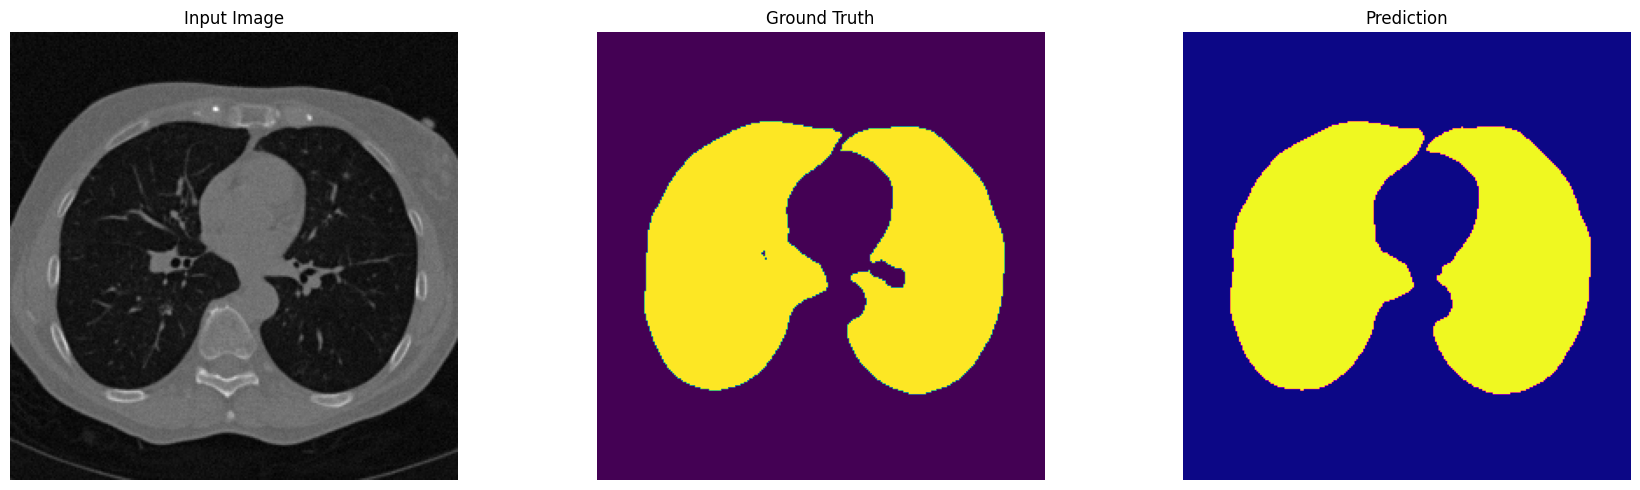

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# === Load Data ===
data = np.load("/kaggle/working/preprocessed_data/lung_segmentation_data.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

# === Dice Loss ===
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / 
                (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth))

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

# === SE Attention Block ===
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

# === Convolution Block ===
def conv_block(x, filters, kernel_size=3, activation='relu', attention=True):
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    if attention:
        x = se_block(x)
    return x

# === Attention U-Net ===
def build_attention_unet(input_shape, num_classes, base_filters=16, attention=True):
    inputs = layers.Input(shape=input_shape)

    e1 = conv_block(inputs, base_filters, attention=attention)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = conv_block(p1, base_filters * 2, attention=attention)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = conv_block(p2, base_filters * 4, attention=attention)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    e4 = conv_block(p3, base_filters * 8, attention=attention)
    p4 = layers.MaxPooling2D((2, 2))(e4)

    b = conv_block(p4, base_filters * 16, attention=attention)

    u4 = layers.Conv2DTranspose(base_filters * 8, 2, strides=(2, 2), padding='same')(b)
    u4 = layers.Concatenate()([u4, e4])
    d4 = conv_block(u4, base_filters * 8, attention=attention)

    u3 = layers.Conv2DTranspose(base_filters * 4, 2, strides=(2, 2), padding='same')(d4)
    u3 = layers.Concatenate()([u3, e3])
    d3 = conv_block(u3, base_filters * 4, attention=attention)

    u2 = layers.Conv2DTranspose(base_filters * 2, 2, strides=(2, 2), padding='same')(d3)
    u2 = layers.Concatenate()([u2, e2])
    d2 = conv_block(u2, base_filters * 2, attention=attention)

    u1 = layers.Conv2DTranspose(base_filters, 2, strides=(2, 2), padding='same')(d2)
    u1 = layers.Concatenate()([u1, e1])
    d1 = conv_block(u1, base_filters, attention=attention)

    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(d1)
    return models.Model(inputs, outputs)

# === Visualization Functions ===
def display_sample(image, mask, prediction=None, colored=False):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask.squeeze(), cmap='viridis' if colored else 'gray')
    plt.axis('off')

    if prediction is not None:
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(prediction.squeeze(), cmap='plasma' if colored else 'gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], '*-', label='Train Acc')
    plt.plot(history.history['val_accuracy'], '*-', label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '*-', label='Train Loss')
    plt.plot(history.history['val_loss'], '*-', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Train with Best Parameters ===
batch_size = 16
model = build_attention_unet((256, 256, 1), num_classes=1, base_filters=16, attention=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000658),
    loss=bce_dice_loss,
    metrics=['accuracy', metrics.Precision(), metrics.Recall()]
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).shuffle(100)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

history = model.fit(train_ds, epochs=100, validation_data=val_ds)

# === Plot Accuracy & Loss ===
plot_history(history)

# === Predict on Test Set ===
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)

# === Evaluation ===
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Confusion Matrix
cm = confusion_matrix(y_test_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_flat, y_pred_flat))

# === Show Predictions ===
for i in range(3):
    display_sample(X_test[i], y_test[i], y_pred[i], colored=True)


In [16]:
from sklearn.metrics import roc_auc_score, jaccard_score, f1_score

# Flattened values
y_true = y_test.flatten()
y_pred_flat = y_pred.flatten()
y_prob_flat = y_pred_probs.flatten()

# Dice Coefficient (aka F1 score for segmentation)
dice = f1_score(y_true, y_pred_flat)

# IoU (Jaccard Index)
iou = jaccard_score(y_true, y_pred_flat)

# AUC (Area Under Curve)
auc = roc_auc_score(y_true, y_prob_flat)

# Print all
print(f"Dice Coefficient (DSC): {dice:.4f}")
print(f"IoU (Jaccard Index):   {iou:.4f}")
print(f"AUC Score:             {auc:.4f}")


Dice Coefficient (DSC): 0.9770
IoU (Jaccard Index):   0.9551
AUC Score:             0.9968


In [17]:
# Extract sets
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

# Print counts
print("📊 Dataset Sizes:")
print(f"Training Images:   {X_train.shape[0]}")
print(f"Validation Images: {X_val.shape[0]}")
print(f"Testing Images:    {X_test.shape[0]}")


📊 Dataset Sizes:
Training Images:   186
Validation Images: 26
Testing Images:    55


In [18]:
model = build_attention_unet(
    input_shape=(256, 256, 1),
    num_classes=1,
    base_filters=16,
    attention=True
)

# Print model summary
model.summary()

# Alternatively, print total parameter counts
total_params = model.count_params()
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])

print(f"\n🔢 Total Parameters:        {total_params:,}")
print(f"✅ Trainable Parameters:    {trainable_params:,}")
print(f"🛑 Non-Trainable Parameters:{non_trainable_params:,}")


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_627 (Conv2D)       │ (None, 256, 256, 16)   │            160 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_594   │ (None, 256, 256, 16)   │             64 │ conv2d_627[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_594            │ (None, 256, 256, 16)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_628 (Conv2D)       │ (None, 256, 256, 16)   │          2,320 │ activation_594[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_595   │ (None, 256, 256, 16)   │             64 │ conv2d_628[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_595            │ (None, 256, 256, 16)   │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 16)             │              0 │ activation_595[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_468 (Dense)         │ (None, 1)              │             17 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_469 (Dense)         │ (None, 16)             │             32 │ dense_468[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_234 (Reshape)     │ (None, 1, 1, 16)       │              0 │ dense_469[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_234 (Multiply)   │ (None, 256, 256, 16)   │              0 │ activation_595[0][0],  │
│                           │                        │                │ reshape_234[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_132         │ (None, 128, 128, 16)   │              0 │ multiply_234[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_629 (Conv2D)       │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_132[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_596   │ (None, 128, 128, 32)   │            128 │ conv2d_629[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,961,119 (7.48 MB)

 Trainable params: 1,958,175 (7.47 MB)

 Non-trainable params: 2,944 (11.50 KB)


🔢 Total Parameters:        1,961,119
✅ Trainable Parameters:    1,958,175
🛑 Non-Trainable Parameters:2,944


In [25]:
from rich.console import Console
from rich.table import Table

# Create the table
table = Table(title="Attention U-Net Segmentation Results", title_style="bold magenta")

table.add_column("Params", style="bold cyan")
table.add_column("Value", style="bold black")

# Add rows
table.add_row("Model", "Attention U-Net (SE Block)")
table.add_row("Size", "7.48 MB")
table.add_row("DSC", "0.9770")
table.add_row("PRE", "0.97")
table.add_row("REC", "0.99")
table.add_row("IoU", "0.9551")
table.add_row("ACC", "0.99")
table.add_row("AUC", "0.9968")
table.add_row("TrainingTime", "180 sec")

# Display table
console = Console()
console.print(table)


    Attention U-Net Segmentation Results     
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Params       ┃ Value                      ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model        │ Attention U-Net (SE Block) │
│ Size         │ 7.48 MB                    │
│ DSC          │ 0.9770                     │
│ PRE          │ 0.97                       │
│ REC          │ 0.99                       │
│ IoU          │ 0.9551                     │
│ ACC          │ 0.99                       │
│ AUC          │ 0.9968                     │
│ TrainingTime │ 180 sec                    │
└──────────────┴────────────────────────────┘

# Basic U-Net

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7619 - dice_coef: 0.2995 - loss: 0.6411 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - val_accuracy: 0.7589 - val_dice_coef: 0.2676 - val_loss: 0.5645 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7624 - dice_coef: 0.2479 - loss: 0.5637 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - val_accuracy: 0.7589 - val_dice_coef: 0.2651 - val_loss: 0.5395 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7610 - dice_coef: 0.2654 - loss: 0.5368 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00 - val_accuracy: 0.7589 - val_dice_coef: 0.2783 - val_loss: 0.5262 - val_precision_33: 0.0000e+00 - val_recall_33: 0.0000e+00
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7643 - dice_coef: 0.2632 - loss: 0.5101 - precision_33: 0.0000e+00 - recall_33: 0.0000

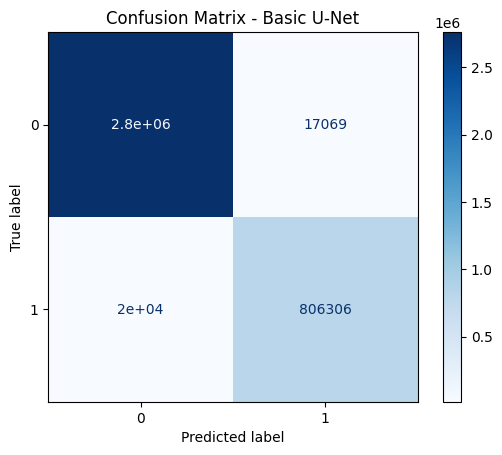

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, jaccard_score
import matplotlib.pyplot as plt

# === Load Data ===
data = np.load("/kaggle/working/preprocessed_data/lung_segmentation_data.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

# === Dice Metric ===
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# === U-Net Blocks ===
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=(2, 2), padding="same")(x)
    x = layers.Concatenate()([x, skip])
    return conv_block(x, filters)

# === Build Basic U-Net ===
def build_unet(input_shape=(256, 256, 1), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b = conv_block(p4, 256)

    d4 = decoder_block(b, s4, 128)
    d3 = decoder_block(d4, s3, 64)
    d2 = decoder_block(d3, s2, 32)
    d1 = decoder_block(d2, s1, 16)

    outputs = layers.Conv2D(num_classes, 1, activation="sigmoid")(d1)
    return models.Model(inputs, outputs)

# === Prepare Dataset ===
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).shuffle(100)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

# === Compile & Train ===
model = build_unet()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.Precision(), metrics.Recall(), dice_coef])

history = model.fit(train_ds, validation_data=val_ds, epochs=100, verbose=1)

# === Evaluation ===
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(np.uint8)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Metrics
dsc = dice_coef(y_test, y_pred).numpy()
iou = jaccard_score(y_test_flat, y_pred_flat, average='binary')
acc = np.mean(y_test_flat == y_pred_flat)
auc = roc_auc_score(y_test_flat, y_pred_probs.flatten())
report = classification_report(y_test_flat, y_pred_flat, digits=4)

# === Display Results ===
print("📊 Basic U-Net Evaluation Results")
print(f"Dice Coefficient (DSC): {dsc:.4f}")
print(f"IoU (Jaccard Index):    {iou:.4f}")
print(f"Accuracy (ACC):         {acc:.4f}")
print(f"AUC Score:              {auc:.4f}")
print("\nClassification Report:\n", report)

# Optional: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Basic U-Net")
plt.show()
